# Connect to Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Import Dependencies

In [2]:
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import re

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms as tfms
%matplotlib inline

# Prepare Colab environement.

Since we run our experiments majorly in Colab. It is important to note that the cells below help us perform changes to the environemnt that are needed before training.

In [3]:
mkdir /content/data

In [4]:
mkdir /content/models_200

In [5]:
cp /content/drive/MyDrive/RL-proj/data/Archive.zip /content/data

In [6]:
!unzip /content/data/Archive.zip -d /content/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/IMG/right_2016_12_01_13_33_20_597.jpg  
  inflating: /content/data/IMG/center_2016_12_01_13_33_00_234.jpg  
  inflating: /content/data/IMG/left_2016_12_01_13_46_37_006.jpg  
  inflating: /content/data/IMG/center_2016_12_01_13_46_15_740.jpg  
  inflating: /content/data/IMG/center_2016_12_01_13_43_27_798.jpg  
  inflating: /content/data/IMG/left_2016_12_01_13_44_34_038.jpg  
  inflating: /content/data/IMG/center_2016_12_01_13_34_08_679.jpg  
  inflating: /content/data/IMG/left_2016_12_01_13_39_45_876.jpg  
  inflating: /content/data/IMG/left_2016_12_01_13_43_53_287.jpg  
  inflating: /content/data/IMG/left_2016_12_01_13_42_07_996.jpg  
  inflating: /content/data/IMG/right_2016_12_01_13_33_48_682.jpg  
  inflating: /content/data/IMG/right_2016_12_01_13_39_47_105.jpg  
  inflating: /content/data/IMG/left_2016_12_01_13_42_27_084.jpg  
  inflating: /content/data/IMG/left_2016_12_01_13_46_15_434.jpg  
  inflating: /

# Split Data into Training and Validation

In [7]:
# Read the dataset and split.
# use stratified split.
from collections import Counter

data_df = pd.read_csv('data/driving_log.csv', header=None)
column_names = data_df.head(1).values[0]
data_df = data_df.iloc[1: , :]
data_df.set_axis(column_names, axis=1, inplace=True)

data_df['steering'] = data_df['steering'].astype(float)

# Add new augment column for later.
data_df['augment'] = False
counts = Counter(data_df['steering'])

for r in data_df.groupby('steering'):
  if(counts[r[0]] == 1):
    r_copy = r
    r_copy[1]['augment'] = True
    data_df = data_df.append(r_copy[1], ignore_index= True)

# Verification for later.
# counts = Counter(data_df['steering'])
# print(counts)

# Stratified split to capture the long-tailed nature of the dataset.
X = data_df[['center','left','right', 'augment']].values
y = data_df['steering'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25)

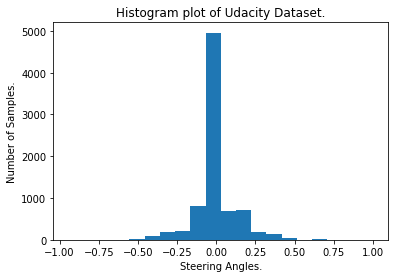

In [12]:
"""
  Plotting Statistics for the Dataset.
"""
plt.hist(y, bins=20)
plt.title('Histogram plot of Udacity Dataset.')
plt.ylabel('Number of Samples.')
plt.xlabel('Steering Angles.')
plt.show()

# Util function for FDS

In [10]:
"""
  Motivated from:
  https://github.com/YyzHarry/imbalanced-regression
  
"""
def calibrate_mean_var(matrix, m1, v1, m2, v2, clip_min=0.1, clip_max=10):
    if torch.sum(v1) < 1e-10:
        return matrix
    if (v1 == 0.).any():
        valid = (v1 != 0.)
        factor = torch.clamp(v2[valid] / v1[valid], clip_min, clip_max)
        matrix[:, valid] = (matrix[:, valid] - m1[valid]) * torch.sqrt(factor) + m2[valid]
        return matrix

    factor = torch.clamp(v2 / v1, clip_min, clip_max)
    return (matrix - m1) * torch.sqrt(factor) + m2

# FDS Layer

In [11]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.signal.windows import triang
import torch
import torch.nn as nn
import torch.nn.functional as F

"""
    The Last layer for Feature Distribution Sampling. 
    Code inspired from: https://github.com/YyzHarry/imbalanced-regression
"""
class FDS(nn.Module):

    def __init__(self, feature_dim, bucket_num=10, bucket_start=3, start_update=0, start_smooth=1,
                 kernel='gaussian', ks=5, sigma=2, momentum=0.9):
        super(FDS, self).__init__()
        self.feature_dim = feature_dim
        self.bucket_num = bucket_num
        self.bucket_start = bucket_start
        self.kernel_window = self._get_kernel_window(kernel, ks, sigma)
        self.half_ks = (ks - 1) // 2
        self.momentum = momentum
        self.start_update = start_update
        self.start_smooth = start_smooth

        self.register_buffer('epoch', torch.zeros(1).fill_(start_update))
        self.register_buffer('running_mean', torch.zeros(bucket_num - bucket_start, feature_dim))
        self.register_buffer('running_var', torch.ones(bucket_num - bucket_start, feature_dim))
        self.register_buffer('running_mean_last_epoch', torch.zeros(bucket_num - bucket_start, feature_dim))
        self.register_buffer('running_var_last_epoch', torch.ones(bucket_num - bucket_start, feature_dim))
        self.register_buffer('smoothed_mean_last_epoch', torch.zeros(bucket_num - bucket_start, feature_dim))
        self.register_buffer('smoothed_var_last_epoch', torch.ones(bucket_num - bucket_start, feature_dim))
        self.register_buffer('num_samples_tracked', torch.zeros(bucket_num - bucket_start))

    @staticmethod
    def _get_kernel_window(kernel, ks, sigma):
        assert kernel in ['gaussian', 'triang', 'laplace']
        half_ks = (ks - 1) // 2
        if kernel == 'gaussian':
            base_kernel = [0.] * half_ks + [1.] + [0.] * half_ks
            base_kernel = np.array(base_kernel, dtype=np.float32)
            kernel_window = gaussian_filter1d(base_kernel, sigma=sigma) / sum(gaussian_filter1d(base_kernel, sigma=sigma))
        elif kernel == 'triang':
            kernel_window = triang(ks) / sum(triang(ks))
        else:
            laplace = lambda x: np.exp(-abs(x) / sigma) / (2. * sigma)
            kernel_window = list(map(laplace, np.arange(-half_ks, half_ks + 1))) / sum(map(laplace, np.arange(-half_ks, half_ks + 1)))

        return torch.tensor(kernel_window, dtype=torch.float32).cuda()

    def _update_last_epoch_stats(self):
        self.running_mean_last_epoch = self.running_mean
        self.running_var_last_epoch = self.running_var

        self.smoothed_mean_last_epoch = F.conv1d(
            input=F.pad(self.running_mean_last_epoch.unsqueeze(1).permute(2, 1, 0),
                        pad=(self.half_ks, self.half_ks), mode='reflect'),
            weight=self.kernel_window.view(1, 1, -1), padding=0
        ).permute(2, 1, 0).squeeze(1)
        self.smoothed_var_last_epoch = F.conv1d(
            input=F.pad(self.running_var_last_epoch.unsqueeze(1).permute(2, 1, 0),
                        pad=(self.half_ks, self.half_ks), mode='reflect'),
            weight=self.kernel_window.view(1, 1, -1), padding=0
        ).permute(2, 1, 0).squeeze(1)

    def reset(self):
        self.running_mean.zero_()
        self.running_var.fill_(1)
        self.running_mean_last_epoch.zero_()
        self.running_var_last_epoch.fill_(1)
        self.smoothed_mean_last_epoch.zero_()
        self.smoothed_var_last_epoch.fill_(1)
        self.num_samples_tracked.zero_()

    def update_last_epoch_stats(self, epoch):
        if epoch == self.epoch + 1:
            self.epoch += 1
            self._update_last_epoch_stats()

    def update_running_stats(self, features, labels, epoch):
        if epoch < self.epoch:
            return

        assert self.feature_dim == features.size(1), "Input feature dimension is not aligned!"
        assert features.size(0) == labels.size(0), "Dimensions of features and labels are not aligned!"

        for label in torch.unique(labels):
            if label > self.bucket_num - 1 or label < self.bucket_start:
                continue
            elif label == self.bucket_start:
                curr_feats = features[labels <= label]
            elif label == self.bucket_num - 1:
                curr_feats = features[labels >= label]
            else:
                curr_feats = features[labels == label]
            curr_num_sample = curr_feats.size(0)
            curr_mean = torch.mean(curr_feats, 0)
            curr_var = torch.var(curr_feats, 0, unbiased=True if curr_feats.size(0) != 1 else False)

            self.num_samples_tracked[int(label - self.bucket_start)] += curr_num_sample
            factor = self.momentum if self.momentum is not None else \
                (1 - curr_num_sample / float(self.num_samples_tracked[int(label - self.bucket_start)]))
            factor = 0 if epoch == self.start_update else factor
            self.running_mean[int(label - self.bucket_start)] = \
                (1 - factor) * curr_mean + factor * self.running_mean[int(label - self.bucket_start)]
            self.running_var[int(label - self.bucket_start)] = \
                (1 - factor) * curr_var + factor * self.running_var[int(label - self.bucket_start)]


    def smooth(self, features, labels, epoch):
        if epoch < self.start_smooth:
            return features
        

        labels = labels.squeeze(1)
        for label in torch.unique(labels):
            if label > self.bucket_num - 1 or label < self.bucket_start:
                continue
            elif label == self.bucket_start:
                features[labels <= label] = calibrate_mean_var(
                    features[labels <= label],
                    self.running_mean_last_epoch[int(label - self.bucket_start)],
                    self.running_var_last_epoch[int(label - self.bucket_start)],
                    self.smoothed_mean_last_epoch[int(label - self.bucket_start)],
                    self.smoothed_var_last_epoch[int(label - self.bucket_start)])
            elif label == self.bucket_num - 1:
                features[labels >= label] = calibrate_mean_var(
                    features[labels >= label],
                    self.running_mean_last_epoch[int(label - self.bucket_start)],
                    self.running_var_last_epoch[int(label - self.bucket_start)],
                    self.smoothed_mean_last_epoch[int(label - self.bucket_start)],
                    self.smoothed_var_last_epoch[int(label - self.bucket_start)])
            else:
                features[labels == label] = calibrate_mean_var(
                    features[labels == label],
                    self.running_mean_last_epoch[int(label - self.bucket_start)],
                    self.running_var_last_epoch[int(label - self.bucket_start)],
                    self.smoothed_mean_last_epoch[int(label - self.bucket_start)],
                    self.smoothed_var_last_epoch[int(label - self.bucket_start)])
        return features

# Image Augmentations and Helper Functions

In [12]:
import os
PATH_PREFIX = os.getcwd() + '/data/'

"""
    Image Augmentations and transformations.
    Code from: https://github.com/upul/Behavioral-Cloning
"""
def choose_image(image_paths, steering_angle, path_prefix, is_training=True, transfer=False):
    '''Choose center | left | right and adjust the steering angle accordingly'''


    choice = np.random.choice(3)
    
    if choice == 0: # left
        return cv2.imread(path_prefix + image_paths[1].strip()), steering_angle + 0.2
    
    elif choice == 1: # right
        return cv2.imread(path_prefix + image_paths[2].strip()), steering_angle - 0.2
    
    return cv2.imread(path_prefix + image_paths[0].strip()), steering_angle # center
    

def random_flip(image, steering_angle):
    '''Randomly flip the image horizontally and adjust steering angle'''
    
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle

def random_brightness(image):
    '''Randomly increase or decrease brightness'''
    
    choice = np.random.choice(2)
    
    if choice == 1:
        return image + np.random.randint(1,20)
    
    return image - np.random.randint(0,30)

def augmentation(image_paths, steering_angle, path_prefix=None, is_training=True, transfer=False):
    '''Generate an augmented image'''

    image, steering_angle = choose_image(image_paths, steering_angle, path_prefix, is_training, transfer=transfer)

    image, steering_angle = random_flip(image, steering_angle)
    image = random_brightness(image)
    
    return image, steering_angle

def preprocess_image(img):
    '''Preprocess an image by cropping, resizing and tensorizing'''
    img = img[60:-25,:]
    img = cv2.resize(img, (200, 66))
    img = tfms.ToTensor()(img)
    return img

# Model Architecture

In [13]:
"""
    Model inspiration from: https://arxiv.org/abs/1604.07316
    Referred as the NVIDIA Model.
"""
config = dict(feature_dim=10, start_update=0, start_smooth=1, kernel='gaussian', ks=5, sigma=2)
class FDSNvidiaModel(nn.Module):
    def __init__(self, isFds= False):
        super().__init__()
        self.is_training=True

        self.conv1 = nn.Conv2d(3, 24, 5, 2)
        self.conv2 = nn.Conv2d(24, 36, 5, 2)
        self.conv3 = nn.Conv2d(36, 48, 5, 2)
        self.conv4 = nn.Conv2d(48, 64, 3, 1)
        self.conv5 = nn.Conv2d(64, 64, 3, 1)
        
        self.dense = nn.Sequential(nn.Linear(1152, 100),
                                   nn.ELU(),
                                   nn.Dropout(0.25),
                                   nn.Linear(100, 50),
                                   nn.ELU(),
                                   nn.Linear(50, 10),
                                   nn.ELU())

        self.isFds = isFds
        self.linear_last = nn.Linear(10, 1)
        self.FDS = FDS(**config)
        
    def forward(self, x, labels=None, epoch=None):
        
        batch_size = x.size(0)
        
        # Convolutional Pass
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))
        x = F.elu(self.conv5(x))
        
        # Linear Pass
        x = x.reshape(batch_size, -1)
        
        out = self.dense(x)
        smoothed_features = out.clone()

        # Penultimate Layer using FDS smoothing.
        if self.isFds and self.is_training and epoch >= config['start_smooth']:
          smoothed_features = self.FDS.smooth(smoothed_features, labels, epoch)
          preds = self.linear_last(smoothed_features)
          return preds, out
        out = self.linear_last(out)
        return out

# Model Initialization and Weighted MSE

In [14]:
model = FDSNvidiaModel()
model = model.double()
torch.save(model.state_dict(), 'random_start_model.pth')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=2)
def weighted_mse_loss(inputs, targets, weights=None):
    loss = (inputs - targets) ** 2
    if weights is not None:
        loss *= weights.expand_as(loss)
    loss = torch.mean(loss)
    return loss

# Custom DataLoader for PyTorch

In [15]:
from torch.utils.data import Dataset
import pandas as pd
import os
from torch.utils.data import DataLoader
class CustomDataset(Dataset):
    def __init__(self, X, y, dw=None, is_training = True, path_prefix = None, transfer=False, lds=False):
        self.X = X
        self.Y = y
        self.path_prefix = path_prefix
        self.is_training = is_training
        self.transfer = transfer
        self.lds = True
        self.dw = dw
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        image_paths = self.X[idx]
        image_paths[1] = image_paths[1].replace(' ','')
        image_paths[2] = image_paths[2].replace(' ','')
        augment = image_paths[3]
        steering_angle = self.Y[idx]

        # randomly decide to augment or not
        if augment or (self.is_training and np.random.rand() < 0.5) :
            image, steering_angle = augmentation(image_paths, steering_angle, self.path_prefix, self.is_training, transfer=self.transfer)
        else:
            image = cv2.imread(self.path_prefix + image_paths[0])
        image_i = preprocess_image(image)
        steer_i = float(steering_angle)
        

        
        return image_i, steer_i, self.dw(steer_i)[0]

# Training Function

In [16]:
import time
def train(model,
          criterion,
          optimizer, 
          scheduler,
          tag,
          model_name,
          train_dataloader,
          val_dataloader,
          train_steps=5000,
          validation_steps=1000,
          batch_size=32,
          epochs=1,
          device='cuda',
          fds=True,
          transfer=False):
    
    model.to(device)
    
    prev_loss = 100000
    best_weighted_mse = 100000
    
    for current_epoch in range(1, epochs+1):

        t1=time.time()
        
        # TRAIN
        model.train()
        model.is_training=True
        model.isFds = fds
        
        for i, data1 in enumerate(train_dataloader):
            images, steers, wts_steers= data1

            images = images.float().to(device)
            steers = steers.float().to(device)
            wts_steers = wts_steers.float().to(device)
            if model.isFds:
              steers = steers.unsqueeze(1)
            
            # set the optimizer to zero gradients
            optimizer.zero_grad()
            
            # pass the inputs through the model
            training_labels = None
            out = None
            if model.isFds:
              out, training_labels = model(images, steers, current_epoch)
            else:
              out = model(images)
            

            # Calculate Loss
            loss = weighted_mse_loss(out.squeeze(1), steers, wts_steers)

            # Backpropagate
            loss.backward()

            # optimize
            optimizer.step()

            # Update statistics.
            if (model.isFds):
              model.FDS.update_last_epoch_stats(current_epoch)
              model.FDS.update_running_stats(training_labels, steers, current_epoch)
            
        # VALIDATION
        model.eval()
        
        t1 = time.time()
        model.is_training=False
        with torch.no_grad():
            val_losses = []
            weighted_losses = []
            for i, data1 in enumerate(val_dataloader):
                images, steers, steer_weights = data1
                # move the data to selected device
                images = images.float().to(device)
                steers = steers.float().to(device)
                steer_weights = steer_weights.float().to(device)
                # pass the inputs through the model
                out= model(images)
                # calculate loss
                loss = weighted_mse_loss(out, steers)
                weighted_loss = weighted_mse_loss(out,steers,steer_weights)
                val_losses.append(loss.item())
                weighted_losses.append(weighted_loss.item())
                
            
            mean_val_loss = sum(val_losses)/len(val_losses)
            mean_weighted_val_loss = sum(weighted_losses)/len(weighted_losses)
        
        if current_epoch%5==0:
          print(f"\nValidation MSE at epoch={current_epoch}, Loss: {mean_val_loss}")
          print(f'\nValidation weighted loss at epoch={current_epoch}, Loss: {mean_weighted_val_loss}')
        
        # Save model
        if mean_val_loss<prev_loss:
          prev_loss = mean_val_loss
          torch.save(model.state_dict(), model_name)
        if mean_weighted_val_loss<best_weighted_mse:
          best_weighted_mse = mean_weighted_val_loss
        
        scheduler.step()
    return prev_loss, best_weighted_mse

# Installing DenseWeight for DenseLoss

In [17]:
# https://github.com/SteiMi/denseweight
pip install DenseWeight

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 448 kB 5.1 MB/s 


In [18]:
from denseweight import DenseWeight

# Experimentation Pipeline

In [19]:
losses = []
batches = [32]
alphas = [0.8, 1.0, 1.2]

"""
  The function below demonstrates our experimentation pipeline.
"""
def pipeline(fds = False, transfer=True):
  # Validation weights.
  dw_val = DenseWeight(alpha=0.5)
  dw_val.fit(y)
  val_set = CustomDataset(X_val, y_val, dw=dw_val, is_training=False, path_prefix = os.getcwd() + '/data/')

  train_set = train_dataloader = None
  for alpha in alphas:
    # Get weights per sample based on alpha
    dw = DenseWeight(alpha=alpha)
    dw.fit(y)

    # Send into train-data loader.
    train_set = CustomDataset(X_train, y_train, dw=dw, is_training=True, path_prefix = os.getcwd() + '/data/')

    for bsz in batches:

      # Load model from random initialization earlier.
      model = FDSNvidiaModel(isFds=fds)
      model.load_state_dict(torch.load('random_start_model.pth'))
      if fds:
        model.FDS = FDS(**config)
      optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
      scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=2)

      print(f'Started Training for batch-size:{bsz}')
      model_name = f'{os.getcwd()}/models_200/' + f'model_fds-{fds}-alpha-{alpha}-transfer-{transfer}-batch-{bsz}.pth'

      train_dataloader = DataLoader(train_set, batch_size=bsz, shuffle=False)
      val_dataloader = DataLoader(val_set, batch_size=bsz, shuffle=False)

      mse_loss, weighted_loss = train(
          model, criterion, optimizer, scheduler, tag='plains', 
          epochs=30, device='cuda', model_name=model_name, 
          train_dataloader=train_dataloader, val_dataloader=val_dataloader, fds=fds, transfer=transfer
      )
      stats = {
          'model_name': model_name,'alpha': alpha, 'batch_size': bsz, 
          'validation_mse_loss': mse_loss, 'validation_weighted_loss': weighted_loss,
          'fdsApplied': fds,
      }
      losses.append(stats)
      print(stats)

In [20]:
# Checking for Vanilla and DenseWeight(LDS)
pipeline(fds = False, transfer=False)

In [21]:
# Checking for FDS and DenseWeight + FDS.
pipeline(fds = True, transfer=False)

Started Training for batch-size:32

Validation MSE at epoch=5, Loss: 0.016273243714951806

Validation weighted loss at epoch=5, Loss: 0.022735930580113615

Validation MSE at epoch=10, Loss: 0.015590666098490594

Validation weighted loss at epoch=10, Loss: 0.022042296900753936

Validation MSE at epoch=15, Loss: 0.01573788933455944

Validation weighted loss at epoch=15, Loss: 0.022251978442664185

Validation MSE at epoch=20, Loss: 0.01577013856657441

Validation weighted loss at epoch=20, Loss: 0.022298864517656582

Validation MSE at epoch=25, Loss: 0.015516338348832159

Validation weighted loss at epoch=25, Loss: 0.021933088463450236

Validation MSE at epoch=30, Loss: 0.01576060420715265

Validation weighted loss at epoch=30, Loss: 0.022286530598879806
{'model_name': '/content/models_200/model_fds-True-alpha-0.8-transfer-False-batch-32.pth', 'alpha': 0.8, 'batch_size': 32, 'validation_mse_loss': 0.015511745742211739, 'validation_weighted_loss': 0.021919744251857675, 'fdsApplied': True}


In [22]:
# View the results of MSE. 
results = pd.DataFrame.from_dict(losses)
results

,model_name,alpha,batch_size,validation_mse_loss,validation_weighted_loss,fdsApplied
0,/content/models_200/model_fds-True-alpha-0.8-t...,0.8,32,0.015512,0.021920,True
1,/content/models_200/model_fds-True-alpha-1.0-t...,1.0,32,0.015484,0.021885,True
2,/content/models_200/model_fds-True-alpha-1.2-t...,1.2,32,0.015484,0.021884,True


In [23]:
results.to_csv('project_results.csv')

In [24]:
!zip -r /content/models_200.zip /content/models_200

  adding: content/models_200/ (stored 0%)
  adding: content/models_200/model_fds-True-alpha-0.8-transfer-False-batch-32.pth (deflated 8%)
  adding: content/models_200/model_fds-True-alpha-1.0-transfer-False-batch-32.pth (deflated 8%)
  adding: content/models_200/model_fds-True-alpha-1.2-transfer-False-batch-32.pth (deflated 8%)
